In [1]:
import json
prettyprint = lambda x: json.dumps(x, indent=4, sort_keys=True)

## Exploring the data first

In [2]:
#This assumes you have all_plans_with_wires.json in the same folder as the notebook.
with open('all_plans_with_wires.json', 'r') as f:
    aq_plans_json = json.load(f)

In [3]:
print(len(aq_plans_json)) #9616
print(prettyprint(aq_plans_json[9615]))

9616
{
    "created_at": "2019-05-23T16:45:31.000-07:00",
    "id": 33674,
    "operations": [
        {
            "created_at": "2019-05-23T16:47:56.000-07:00",
            "field_values": [
                {
                    "rid": 6753363,
                    "role": "input",
                    "sample": {
                        "rid": 6753367,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753364,
                    "role": "input",
                    "sample": {
                        "rid": 6753369,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753365,
                    "role": "output",
                    "sample": {
                        "rid": 6753371,
                        "sample_type_id": 5
                    },
   

In [4]:
from pandas.io.json import json_normalize
operations_df = json_normalize(aq_plans_json, 
                       record_path='operations', 
                       meta=['id', 'status'],
                       record_prefix='op.')

/Users/danyfu/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/danyfu/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
print(operations_df['id'].nunique()) #should be 9616, not sure how we lost 14 plans

9602


In [6]:
operations_df.head(5)

,op.created_at,op.field_values,op.id,op.operation_type,op.operation_type_id,op.rid,op.status,op.updated_at,op.user_id,id,status
0,2017-07-13T08:29:06.000-07:00,"[{'rid': 19237, 'role': 'output', 'sample': {'...",17,Cloning,48,19235,done,2017-07-13T08:50:43.000-07:00,66,9,None
1,2017-07-13T08:29:06.000-07:00,"[{'rid': 19247, 'role': 'output', 'sample': {'...",18,Cloning,48,19245,done,2017-07-13T08:50:43.000-07:00,66,10,None
2,2017-07-13T08:58:15.000-07:00,"[{'rid': 19279, 'role': 'input', 'sample': {'r...",27,Cloning,20,19270,error,2017-07-13T09:17:41.000-07:00,17,13,None
3,2017-07-13T08:58:15.000-07:00,"[{'rid': 19292, 'role': 'input', 'sample': {'r...",28,Cloning,19,19271,error,2017-07-13T09:17:41.000-07:00,17,13,None
4,2017-07-13T08:58:15.000-07:00,"[{'rid': 19304, 'role': 'input', 'sample': {'r...",29,Cloning,18,19272,error,2017-07-13T09:17:41.000-07:00,17,13,None


In [7]:
operations_df = operations_df.drop(columns=['op.created_at', 'op.field_values', 'op.rid', 'op.status', 'op.updated_at']) # drop irrelevant columns
operations_df = operations_df.rename(index=str, columns={"op.operation_type": "op.category"}) #rename for clarity
print(operations_df['id'].nunique())
operations_df.head(5)

9602


,op.id,op.category,op.operation_type_id,op.user_id,id,status
0,17,Cloning,48,66,9,None
1,18,Cloning,48,66,10,None
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None


## Filter plans by status

In [8]:
# All possible plan statuses 
print(operations_df['status'].unique()) # [None, 'planning', 'template', 'system_template']

# Find "real" plans by filtering out any plans that are "planning" or templates
real_operations_df = operations_df.loc[operations_df['status'].isnull()]
print(real_operations_df['id'].nunique()) #8343

[None 'template' 'planning' 'system_template']
8343


## Filter islands

In [13]:
op_counts_df = real_operations_df.groupby('id')['op.operation_type_id'].nunique().reset_index()
island_list = op_counts_df.loc[op_counts_df['op.operation_type_id'] == 1]['id'] #the op id here is actually a count

# islands = real_operations_df[real_operations_df.id.isin(list(island_list))]['op.operation_type_id'].unique()
# print(len(islands))
# print(islands)

In [14]:
real_operations_without_islands_df = real_operations_df[~real_operations_df.id.isin(list(island_list))]
NUM_REAL_PLANS = real_operations_without_islands_df['id'].nunique() #5,969 plans
NUM_REAL_PLANS

5969

In [15]:
# get some basic stats of the final dataset we're working with
ops_per_plan = real_operations_without_islands_df.groupby("id")['op.id'].nunique()
print("mean:", ops_per_plan.mean()) #~14
print("standard dev:", ops_per_plan.std()) #~27
print("max:", ops_per_plan.max()) #643
print("id of plan with most operations:", ops_per_plan.idxmax()) #id of the plan with the most operations
print("min:", ops_per_plan.min()) #2
print("mode:", ops_per_plan.mode()) #3

mean: 14.235047746691238
standard dev: 27.039897131187086
max: 643
id of plan with most operations: 30442
min: 2
mode: 0    3
dtype: int64


In [16]:
real_operations_without_islands_df.head(5)

,op.id,op.category,op.operation_type_id,op.user_id,id,status
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None
5,30,Cloning,30,17,13,None
6,31,Cloning,29,17,13,None


## Create graph with weighted edges

In [19]:
'''create a wires dataframe'''
# import pandas as pd
# all_wires = [w for obj in aq_plans_json for w in obj['wires']]
# wires_df = pd.DataFrame(all_wires)

from pandas.io.json import json_normalize
wires_df = json_normalize(aq_plans_json, record_path='wires')
wires_df = wires_df.drop(columns=['rid', 'sample', 'id']) # drop irrelevant columns
wires_df = wires_df.rename(index=str, columns={"from": "src_op_id", "to": "dest_op_id"}) #rename for clarity
wires_df = wires_df[~wires_df.isin(['NaN']).any(axis=1)]
wires_df['dest_op_id'] = wires_df['dest_op_id'].astype(int)
wires_df['src_op_id'] = wires_df['src_op_id'].astype(int)
wires_df.shape

(182038, 2)

In [20]:
'''inner merge with destination to find op type'''
merged_to = wires_df.merge(real_operations_without_islands_df, left_on='dest_op_id', right_on='op.id', how='inner')
merged_pairs_df = merged_to[['src_op_id', 'dest_op_id', 'op.operation_type_id', 'id']].reset_index()
merged_pairs_df = merged_pairs_df.rename(index=str, columns={"op.operation_type_id": "dest_op_type_id"}) #rename for clarity
merged_pairs_df.head(10)

,index,src_op_id,dest_op_id,dest_op_type_id,id
0,0,28,27,20,13
1,1,28,27,20,13
2,2,29,28,19,13
3,3,29,28,19,13
4,4,30,29,18,13
5,5,30,29,18,13
6,6,31,30,30,13
7,7,31,30,30,13
8,8,32,31,29,13
9,9,32,31,29,13


In [21]:
'''inner merge with source to find op type'''
edge_pairs_df = merged_pairs_df.merge(real_operations_without_islands_df, left_on='src_op_id', right_on='op.id', how='inner')
edge_pairs_df = edge_pairs_df[['src_op_id', 'dest_op_id', 'op.operation_type_id', 'dest_op_type_id']].reset_index()
edge_pairs_df = edge_pairs_df.rename(index=str, columns={"op.operation_type_id": "src_op_type_id", 'id': 'plan_id'}) #rename for clarity
edge_pairs_df.head(10)

,index,src_op_id,dest_op_id,src_op_type_id,dest_op_type_id
0,0,28,27,19,20
1,1,28,27,19,20
2,2,29,28,18,19
3,3,29,28,18,19
4,4,30,29,30,18
5,5,30,29,30,18
6,6,31,30,29,30
7,7,31,30,29,30
8,8,32,31,28,29
9,9,32,31,28,29


### Not all valid nodes have edges

In [25]:
all_nodes = real_operations_without_islands_df['op.operation_type_id'].unique()
print(len(all_nodes))

nodes_with_edges = edge_pairs_df['src_op_type_id'].append(edge_pairs_df['dest_op_type_id']).unique()
print(len(nodes_with_edges))

no_edge_nodes = list(set(nodes) - set(all_set))
no_edge_ops = real_operations_without_islands_df.loc[real_operations_without_islands_df['op.operation_type_id'].isin(no_edge_nodes)].shape[0]
print('% of op types with no edges:', (len(no_edge_nodes)/len(nodes)) * 100)
print('% of ops with no edges:', (no_edge_ops/real_operations_without_islands_df.shape[0]) * 100)

294
264
% of op types with no edges: 10.204081632653061
% of ops with no edges: 2.5373959914792454


In [26]:
import networkx as nx
from itertools import chain

G = nx.Graph()   
G.add_nodes_from(nodes_with_edges)
pair_counts = edge_pairs_df.groupby(['src_op_type_id', 'dest_op_type_id']).size().reset_index()
weighted_edges = list(pair_counts.itertuples(index=False, name=None))
G.add_weighted_edges_from(weighted_edges)

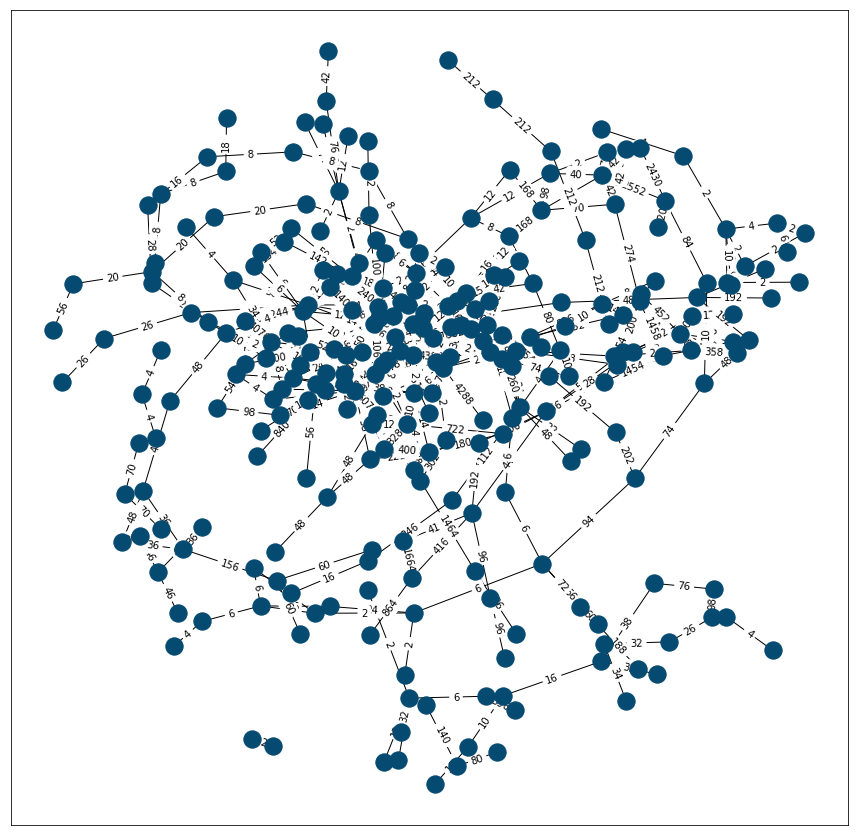

In [29]:
import min_k_cut as mc

mc.draw_graph(G)

We run the k mincut algorithm many times over the range of 50% to 70% of the vertices so we pick a good test/train split 

In [30]:
contractable = mc.make_contractable(G)
num_nodes = len(G.nodes)
all_cuts = mc.run_many_over_range(contractable, 50, range(int(num_nodes*0.5),int(num_nodes*0.7)))

Text(0, 0.5, 'Size of cut')

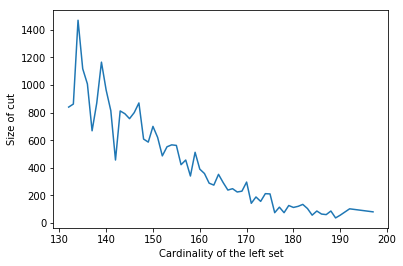

In [31]:
import matplotlib.pyplot as plt
(xs,ys) = list(zip(*map(lambda k: (k,all_cuts[k]['cut_size']), all_cuts)))
plt.plot(xs,ys)
plt.xlabel("Cardinality of the left set")
plt.ylabel("Size of cut")

In [34]:
all_cuts

{132: {'contracted_size': 132,
  'cut_size': 840,
  'kept': <networkx.classes.graph.Graph at 0x1529d2128>,
  'rest': <networkx.classes.graph.Graph at 0x1529d2080>},
 133: {'contracted_size': 133,
  'cut_size': 862,
  'kept': <networkx.classes.graph.Graph at 0x1529d2f98>,
  'rest': <networkx.classes.graph.Graph at 0x1529d2da0>},
 134: {'contracted_size': 134,
  'cut_size': 1470,
  'kept': <networkx.classes.graph.Graph at 0x1531f1240>,
  'rest': <networkx.classes.graph.Graph at 0x1531f1160>},
 135: {'contracted_size': 135,
  'cut_size': 1118,
  'kept': <networkx.classes.graph.Graph at 0x1531f1b38>,
  'rest': <networkx.classes.graph.Graph at 0x1531f1748>},
 136: {'contracted_size': 136,
  'cut_size': 1008,
  'kept': <networkx.classes.graph.Graph at 0x156cc0278>,
  'rest': <networkx.classes.graph.Graph at 0x156cc05f8>},
 137: {'contracted_size': 137,
  'cut_size': 668,
  'kept': <networkx.classes.graph.Graph at 0x14967a320>,
  'rest': <networkx.classes.graph.Graph at 0x1529d2278>},
 138: {

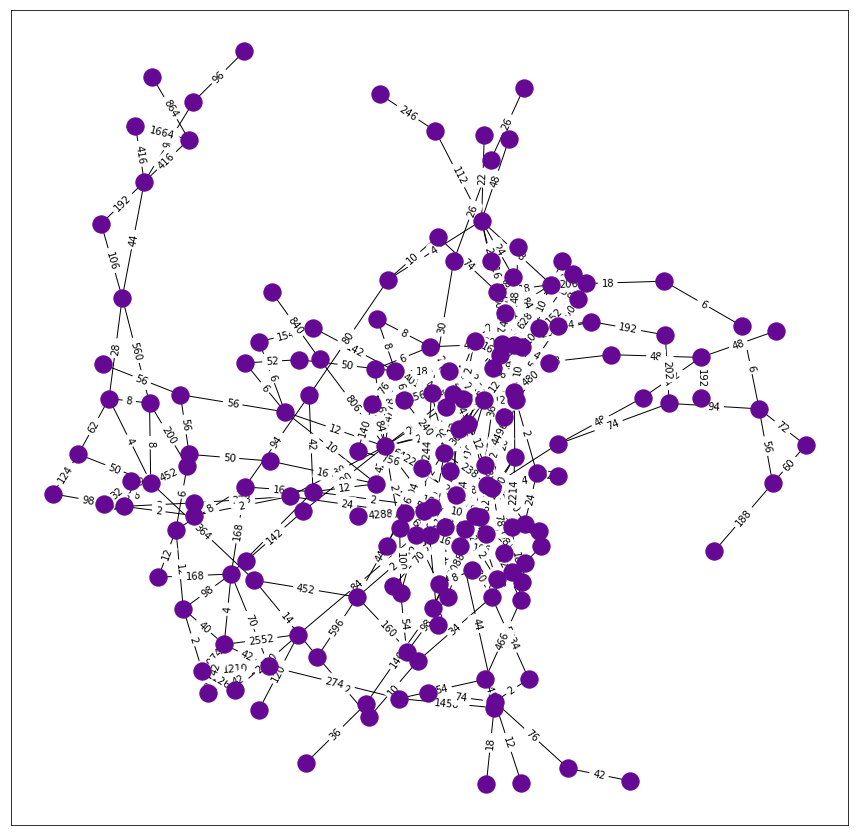

In [37]:
kept = all_cuts[171]['kept']
rest = all_cuts[171]['rest']
mc.draw_graph(kept)

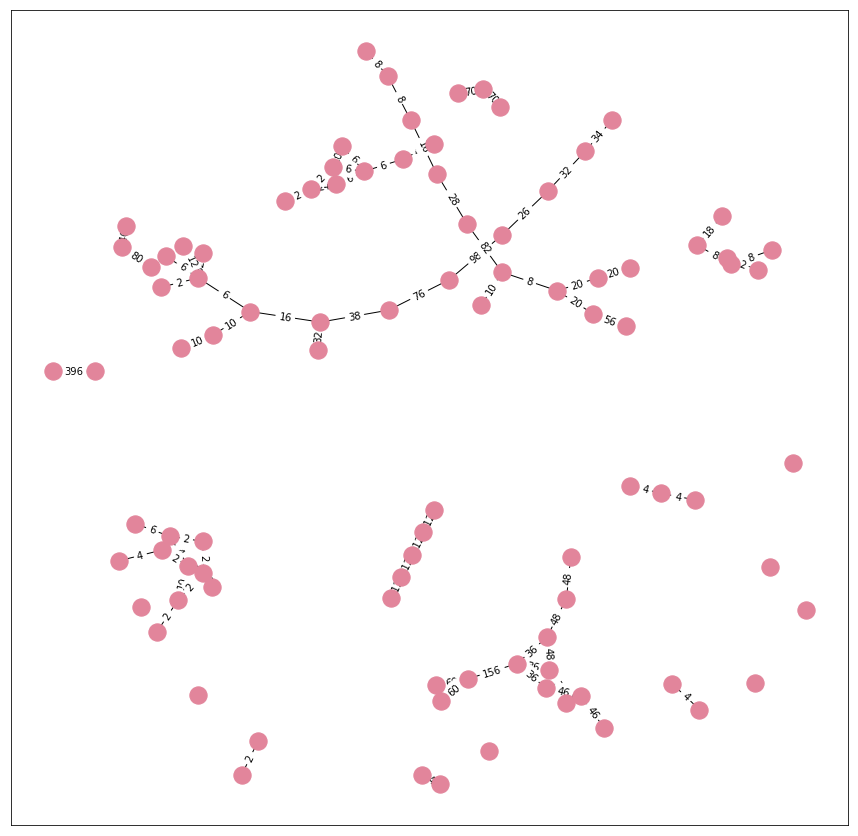

In [38]:
mc.draw_graph(rest)

In [33]:
all_cuts[211]['cut_size']

6